# Data Preparation 

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LEVIRCDDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir_b = os.path.join(images_dir, 'B')  # Pre-change
        self.images_dir_a = os.path.join(images_dir, 'A')  # Post-change
        self.masks_dir = os.path.join(images_dir, 'label')
        self.transform = transform

        # Ensure consistent ordering of files
        self.images_b = sorted(f for f in os.listdir(self.images_dir_b) if f.endswith(('.png', '.jpg', '.jpeg')))
        self.images_a = sorted(f for f in os.listdir(self.images_dir_a) if f.endswith(('.png', '.jpg', '.jpeg')))
        self.masks = sorted(f for f in os.listdir(self.masks_dir) if f.endswith(('.png', '.jpg', '.jpeg')))

    def __len__(self):
        return len(self.images_b)

    def __getitem__(self, idx):
        img_path_b = os.path.join(self.images_dir_b, self.images_b[idx])  # Pre-change
        img_path_a = os.path.join(self.images_dir_a, self.images_a[idx])  # Post-change
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        
        # Load images
        image_b = cv2.imread(img_path_b, cv2.IMREAD_COLOR)  # BGR
        image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB)  # RGB
        image_b = image_b.astype(np.float32) / 255.0  # Normalize to [0, 1]

        image_a = cv2.imread(img_path_a, cv2.IMREAD_COLOR)  # BGR
        image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB)  # RGB
        image_a = image_a.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        mask = mask.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Apply transformations consistently
        if self.transform:
            augmented = self.transform(image=image_b, image1=image_a, mask=mask)  # Pre-change first
            image_b = augmented['image']  # Pre-change
            image_a = augmented['image1']  # Post-change
            mask = augmented['mask']  # Mask
        
        # Convert mask to tensor and add channel dimension
        # Ensure mask is a tensor and normalize
        # if isinstance(mask, np.ndarray):  # If Albumentations outputs a NumPy array
        #     mask = torch.from_numpy(mask).float().unsqueeze(0) / 255.0
        # elif isinstance(mask, torch.Tensor):  # If Albumentations outputs a PyTorch tensor
        mask = mask.unsqueeze(0)

        return image_b, image_a, mask


# Albumentations transformations
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'image1': 'image'})  # Specify additional target for post-change image

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'image1': 'image'})  # Specify additional target for post-change image

# Datasets
LEVIR_train_dataset = LEVIRCDDataset(
    images_dir="/kaggle/input/levir-cd/LEVIR CD/train",
    transform=train_transform
)

LEVIR_val_dataset = LEVIRCDDataset(
    images_dir="/kaggle/input/levir-cd/LEVIR CD/val",
    transform=val_transform
)

LEVIR_test_dataset = LEVIRCDDataset(
    images_dir="/kaggle/input/levir-cd/LEVIR CD/test",
    transform=val_transform
)

# Dataloaders
LEVIR_train_loader = DataLoader(LEVIR_train_dataset, batch_size=16, shuffle=True)
LEVIR_val_loader = DataLoader(LEVIR_val_dataset, batch_size=16, shuffle=False)
LEVIR_test_loader = DataLoader(LEVIR_test_dataset, batch_size=16, shuffle=False)

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Dataset Statistics

In [2]:
print(f'Training Dataset Length: {len(LEVIR_train_dataset)}')
print(f'Validation Dataset Length: {len(LEVIR_val_dataset)}')
print(f'Testing Dataset Length: {len(LEVIR_test_dataset)}')

Training Dataset Length: 445
Validation Dataset Length: 64
Testing Dataset Length: 128


# Data Inspection

In [3]:
import cv2
import numpy as np
import torch

'''Image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train/22678915_15.png")
Mask=image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train_labels/22678915_15.png")

print(f'Original mask shape:{Image.shape}')

print(f'Original mask shape:{Mask.shape}')'''

#print(np.unique(Mask))

image1, image2, mask = LEVIR_train_dataset[10]

print(f'Transformed Image shape:{image1.shape}')
print(f'Transformed Image shape:{image2.shape}')
print(f'Transformed mask shape:{mask.shape}')

print(torch.unique(mask))
print(torch.unique(image1))
print(torch.unique(image2))

print(torch.unique(mask).numel())

Transformed Image shape:torch.Size([3, 256, 256])
Transformed Image shape:torch.Size([3, 256, 256])
Transformed mask shape:torch.Size([1, 256, 256])
tensor([0., 1.])
tensor([0.0137, 0.0157, 0.0176,  ..., 0.9971, 0.9980, 1.0000])
tensor([0.0000e+00, 9.8039e-04, 1.9608e-03,  ..., 9.9804e-01, 9.9902e-01,
        1.0000e+00])
2


# Data Visualization

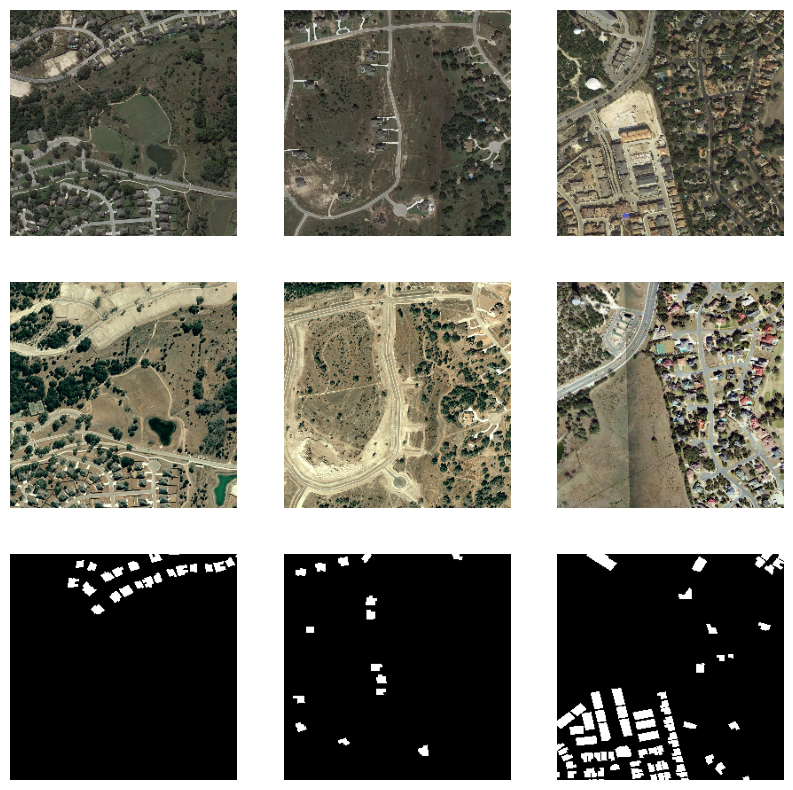

In [4]:
import matplotlib.pyplot as plt

# Set up the plot size and remove axes
plt.figure(figsize=(10, 10))  # Set the figure size to be larger

for i in range(3):
    image1, image2, mask = LEVIR_train_dataset[i]
    
    # Plot Image 1
    plt.subplot(3, 3, i+1)
    plt.imshow(image1.permute(1, 2, 0),cmap='gray')  # Convert tensor to HWC format
    plt.axis('off')  # Remove axes for a cleaner view
    
    # Plot Image 2
    plt.subplot(3, 3, 3+i+1)
    plt.imshow(image2.permute(1, 2, 0),cmap='gray')  # Convert tensor to HWC format
    plt.axis('off')  # Remove axes
    
    # Plot Mask
    plt.subplot(3, 3, 6+i+1)
    plt.imshow(mask.permute(1, 2, 0), cmap='gray')  # Display in grayscale
    plt.axis('off')  # Remove axes

plt.show()

# Siamese U-Net

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic ConvBlock used in both encoder and decoder
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Encoder block: consists of two convolutions followed by max-pooling
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        p = self.pool(x)
        return x, p  # Return both the feature map and pooled result

# Decoder block: uses a transposed convolution (upsampling), followed by convolutions
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(in_channels + skip_channels, out_channels)  # Account for concatenation
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# The main combined Encoder Siamese U-Net architecture
class SiameseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SiameseUNet, self).__init__()
        
        # Encoder blocks for image 1
        self.encoder1a = EncoderBlock(in_channels, 64)
        self.encoder2a = EncoderBlock(64, 128)
        self.encoder3a = EncoderBlock(128, 256)
        self.encoder4a = EncoderBlock(256, 512)
        
        # Encoder blocks for image 2
        self.encoder1b = EncoderBlock(in_channels, 64)
        self.encoder2b = EncoderBlock(64, 128)
        self.encoder3b = EncoderBlock(128, 256)
        self.encoder4b = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(1024, 1024)  # 512 + 512 from both encoders
        
        # Decoder block (shared between both images)
        self.decoder4 = DecoderBlock(1024, 512, 512)
        self.decoder3 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder1 = DecoderBlock(128, 64, 64)

        # Final convolution to output the segmentation map
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # Encoder part for image 1
        e1a, p1a = self.encoder1a(x1)
        e2a, p2a = self.encoder2a(p1a)
        e3a, p3a = self.encoder3a(p2a)
        e4a, p4a = self.encoder4a(p3a)
        
        # Encoder part for image 2
        e1b, p1b = self.encoder1b(x2)
        e2b, p2b = self.encoder2b(p1b)
        e3b, p3b = self.encoder3b(p2b)
        e4b, p4b = self.encoder4b(p3b)

        # Concatenate the encoder outputs from both images (for each layer)
        concat_e4 = torch.cat([e4a, e4b], dim=1)  # Concatenate along the channel dimension
        concat_e3 = torch.cat([e3a, e3b], dim=1)
        concat_e2 = torch.cat([e2a, e2b], dim=1)
        concat_e1 = torch.cat([e1a, e1b], dim=1)

        # Bottleneck
        b = self.bottleneck(torch.cat([p4a, p4b], dim=1))

        # Decoder part (shared across both images)
        d4 = self.decoder4(b, concat_e4)
        d3 = self.decoder3(d4, concat_e3)
        d2 = self.decoder2(d3, concat_e2)
        d1 = self.decoder1(d2, concat_e1)

        # Final output
        out = self.sigmoid(self.final_conv(d1))
        return out


x1 = torch.randn(1, 3, 256, 256)  # Example image 1
x2 = torch.randn(1, 3, 256, 256)  # Example image 2

# Instantiate the Siamese U-Net model
siamese_unet = SiameseUNet(in_channels=3, out_channels=1)

# Get the output
output = siamese_unet(x1, x2)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 256, 256])


# Training Loop

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60, device='cuda'):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_iou_sum = 0
        train_acc_sum = 0
        train_precision_sum = 0
        train_recall_sum = 0
        train_dice_sum = 0
        train_samples = 0
        
        for inputs1, inputs2, labels in train_loader:  # Change: Get two input images
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)  # Forward pass with two inputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs1.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            train_acc_sum += acc * inputs1.size(0)
            train_precision_sum += precision * inputs1.size(0)
            train_recall_sum += recall * inputs1.size(0)
            train_dice_sum += dice * inputs1.size(0)
            train_iou_sum += iou * inputs1.size(0)
            train_samples += inputs1.size(0)
        
        epoch_train_loss = running_train_loss / train_samples
        epoch_train_iou = train_iou_sum / train_samples
        epoch_train_acc = train_acc_sum / train_samples
        epoch_train_precision = train_precision_sum / train_samples
        epoch_train_recall = train_recall_sum / train_samples
        epoch_train_dice = train_dice_sum / train_samples
        
        model.eval()
        running_val_loss = 0.0
        val_iou_sum = 0
        val_acc_sum = 0
        val_precision_sum = 0
        val_recall_sum = 0
        val_dice_sum = 0
        val_samples = 0
        
        with torch.no_grad():
            for inputs1, inputs2, labels in val_loader:  # Change: Get two input images
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)  # Forward pass with two inputs
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs1.size(0)
                acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
                val_acc_sum += acc * inputs1.size(0)
                val_precision_sum += precision * inputs1.size(0)
                val_recall_sum += recall * inputs1.size(0)
                val_dice_sum += dice * inputs1.size(0)
                val_iou_sum += iou * inputs1.size(0)
                val_samples += inputs1.size(0)
        
        epoch_val_loss = running_val_loss / val_samples
        epoch_val_iou = val_iou_sum / val_samples
        epoch_val_acc = val_acc_sum / val_samples
        epoch_val_precision = val_precision_sum / val_samples
        epoch_val_recall = val_recall_sum / val_samples
        epoch_val_dice = val_dice_sum / val_samples
        
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | '
              f'Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f} | '
              f'Train Precision: {epoch_train_precision:.4f}, Val Precision: {epoch_val_precision:.4f} | '
              f'Train Recall: {epoch_train_recall:.4f}, Val Recall: {epoch_val_recall:.4f} | '
              f'Train Dice: {epoch_train_dice:.4f}, Val Dice: {epoch_val_dice:.4f}')

     # Save the final model
    torch.save(model.state_dict(), 'model.pt')

def calculate_metrics(outputs, labels, threshold=0.5):
    predictions = (outputs > threshold).float()
    labels = labels.float()

    tp = torch.sum(predictions * labels)
    tn = torch.sum((1 - predictions) * (1 - labels))
    fp = torch.sum(predictions * (1 - labels))
    fn = torch.sum((1 - predictions) * labels)
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
    
    # IoU
    iou = tp / (tp + fp + fn + 1e-6)
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    
    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize your model
model = SiameseUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with the updated loop
train_model(model, LEVIR_train_loader, LEVIR_val_loader, criterion, optimizer, num_epochs=50, device=device)

# Load the saved model for future use (optional)
loaded_model = SiameseUNet(in_channels=3, out_channels=1).to(device)
loaded_model.load_state_dict(torch.load('model.pt'))
loaded_model.eval()  # Set to evaluation mode for prediction

Epoch 1/50 | Train Loss: 0.5795, Val Loss: 0.4602 | Train IoU: 0.1729, Val IoU: 0.0002 | Train Acc: 0.8050, Val Acc: 0.9580 | Train Precision: 0.1897, Val Precision: 0.6682 | Train Recall: 0.7000, Val Recall: 0.0002 | Train Dice: 0.2864, Val Dice: 0.0004
Epoch 2/50 | Train Loss: 0.4132, Val Loss: 0.3682 | Train IoU: 0.3558, Val IoU: 0.1881 | Train Acc: 0.9514, Val Acc: 0.9635 | Train Precision: 0.4794, Val Precision: 0.8027 | Train Recall: 0.5956, Val Recall: 0.1992 | Train Dice: 0.5227, Val Dice: 0.3058
Epoch 3/50 | Train Loss: 0.3754, Val Loss: 0.3617 | Train IoU: 0.3940, Val IoU: 0.3987 | Train Acc: 0.9565, Val Acc: 0.9548 | Train Precision: 0.5204, Val Precision: 0.4740 | Train Recall: 0.6248, Val Recall: 0.7270 | Train Dice: 0.5622, Val Dice: 0.5695
Epoch 4/50 | Train Loss: 0.3519, Val Loss: 0.3224 | Train IoU: 0.4138, Val IoU: 0.4493 | Train Acc: 0.9601, Val Acc: 0.9626 | Train Precision: 0.5543, Val Precision: 0.5405 | Train Recall: 0.6320, Val Recall: 0.7337 | Train Dice: 0.581

/tmp/ipykernel_30/79170159.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('model.pt'))


SiameseUNet(
  (encoder1a): EncoderBlock(
    (conv1): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2a): EncoderBlock(
    (conv1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(12

# Testing Loop

In [7]:
def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    running_test_loss = 0.0
    test_iou_sum = 0
    test_acc_sum = 0
    test_precision_sum = 0
    test_recall_sum = 0
    test_dice_sum = 0
    test_samples = 0
    
    with torch.no_grad():
        for inputs1, inputs2, labels in test_loader:  # Change: Accept two input images
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            
            # Forward pass with two inputs
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)
            
            running_test_loss += loss.item() * inputs1.size(0)
            
            # Calculate metrics
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            test_acc_sum += acc * inputs1.size(0)
            test_precision_sum += precision * inputs1.size(0)
            test_recall_sum += recall * inputs1.size(0)
            test_dice_sum += dice * inputs1.size(0)
            test_iou_sum += iou * inputs1.size(0)
            test_samples += inputs1.size(0)
    
    # Compute average metrics for the epoch
    epoch_test_loss = running_test_loss / test_samples
    epoch_test_iou = test_iou_sum / test_samples
    epoch_test_acc = test_acc_sum / test_samples
    epoch_test_precision = test_precision_sum / test_samples
    epoch_test_recall = test_recall_sum / test_samples
    epoch_test_dice = test_dice_sum / test_samples
    
    print(f'Test Loss: {epoch_test_loss:.4f} | '
          f'Test IoU: {epoch_test_iou:.4f} | '
          f'Test Acc: {epoch_test_acc:.4f} | '
          f'Test Precision: {epoch_test_precision:.4f} | '
          f'Test Recall: {epoch_test_recall:.4f} | '
          f'Test Dice: {epoch_test_dice:.4f}')
    
    # return {
    #     'loss': epoch_test_loss,
    #     'iou': epoch_test_iou,
    #     'accuracy': epoch_test_acc,
    #     'precision': epoch_test_precision,
    #     'recall': epoch_test_recall,
    #     'dice': epoch_test_dice
    # }

# Evaluate the model on the test set
test_results = test_model(model, LEVIR_test_loader, criterion, device=device)

Test Loss: 0.0810 | Test IoU: 0.6860 | Test Acc: 0.9809 | Test Precision: 0.8292 | Test Recall: 0.7990 | Test Dice: 0.8130


# Result Plotting

Prediction shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])
Image1 shape: torch.Size([3, 256, 256])
Image2 shape: torch.Size([3, 256, 256])
Unique prediction values: tensor([0., 1.])
Prediction shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])
Image1 shape: torch.Size([3, 256, 256])
Image2 shape: torch.Size([3, 256, 256])
Unique prediction values: tensor([0., 1.])
Prediction shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])
Image1 shape: torch.Size([3, 256, 256])
Image2 shape: torch.Size([3, 256, 256])
Unique prediction values: tensor([0., 1.])
Prediction shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])
Image1 shape: torch.Size([3, 256, 256])
Image2 shape: torch.Size([3, 256, 256])
Unique prediction values: tensor([0., 1.])
Prediction shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])
Image1 shape: torch.Size([3, 256, 256])
Image2 shape: torch.Size([3, 256, 256])
Unique prediction values: tensor([0., 1.])


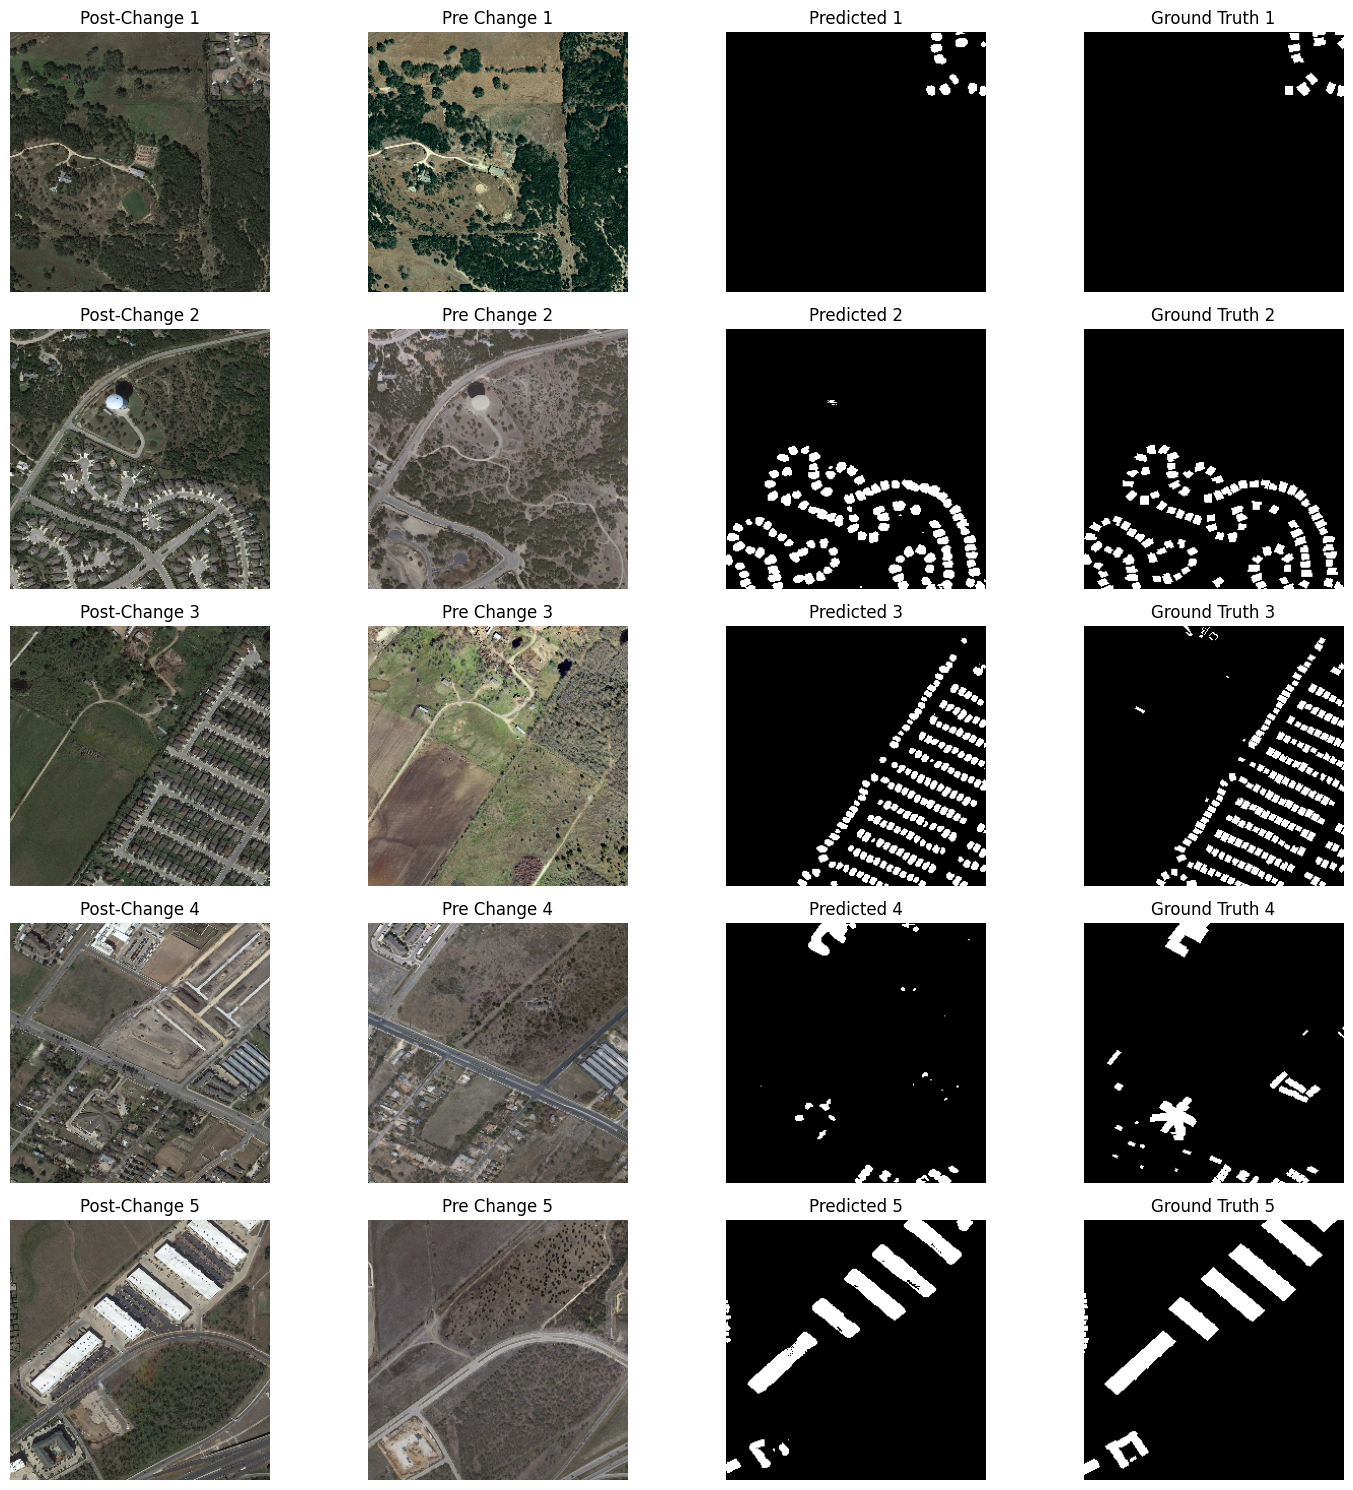

In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# Set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)               # PyTorch random seed
    np.random.seed(seed)                  # NumPy random seed
    random.seed(seed)                     # Python random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs (if using CUDA)

# Set the seed value (choose any integer)
set_seed(42)

# Set up the figure size and the number of subplots
plt.figure(figsize=(15, 15))  # Adjust the figure size for larger plots

# Loop over 5 images from the LEVIR-CD test dataset
for i in range(5):
    # Get image pair and mask from LEVIR-CD test dataset
    image1, image2, mask = LEVIR_test_dataset[i]  # Assuming dataset returns tuple (image1, image2, mask)
    
    # Add batch dimension and move to device
    image1, image2, mask = image1.unsqueeze(dim=0), image2.unsqueeze(dim=0), mask.unsqueeze(dim=0)
    image1, image2, mask = image1.to(device), image2.to(device), mask.to(device)
    
    # Get model prediction (for Siamese U-Net, the model expects two inputs)
    prediction = model(image1, image2)
    prediction = (prediction > 0.5).float()  # Threshold to create binary mask
    
    # Detach the prediction from the graph and move it to the CPU for visualization
    image1 = image1.squeeze().detach().cpu()
    image2 = image2.squeeze().detach().cpu()
    prediction = prediction.squeeze().detach().cpu()
    mask = mask.squeeze().detach().cpu()
    
    # Print the shapes and unique values for debugging
    print(f"Prediction shape: {prediction.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Image1 shape: {image1.shape}")
    print(f"Image2 shape: {image2.shape}")
    print(f"Unique prediction values: {torch.unique(prediction)}")

    # Plot the first input image (Image1)
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(image1.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Post-Change {i+1}")
    
    # Plot the second input image (Image2)
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(image2.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Pre Change {i+1}")
    
    # Plot the predicted segmentation mask
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(prediction, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted {i+1}")
    
    # Plot the ground truth mask
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title(f"Ground Truth {i+1}")

# Adjust the layout and spacing
plt.tight_layout()

# Save the figure as an image file (e.g., PNG)
plt.savefig('Siamese_UNet_with_LEVIR_CD_2.png', bbox_inches='tight')  # Use bbox_inches='tight' to save without extra whitespace

# Show the figure
plt.show()

In [9]:
torch.save(model, 'model1.pt')

In [10]:
torch.save(model.state_dict(), 'siamese_unet.pth')

In [3]:
torch.save(model.state_dict(), 'siamese_unet.pt')

NameError: name 'model' is not defined

In [9]:
torch.save(model, "full_model_siamese.pth")
torch.save(model, "full_model_siamese.pt")
torch.save(model.state_dict(), 'siamese_unet.pth')
torch.save(model.state_dict(), 'siamese_unet.pt')